# Regression Analysis

## 1. Visualizing 

### 1.1 Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### 1.2 EDA: feature relationship

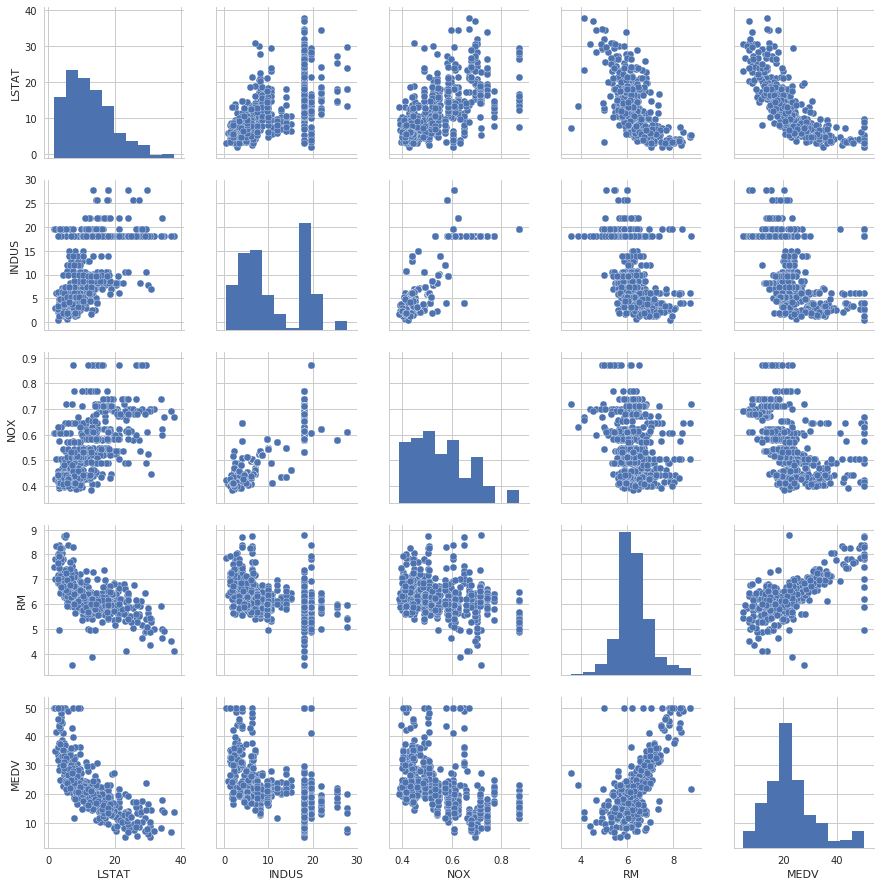

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid',context = 'notebook')
cols = ['LSTAT','INDUS','NOX','RM','MEDV']
sns.pairplot(df[cols],size = 2.5)
sns.reset_orig() # don't use seaborn style stteings

### 1.3 EDA: Heatmap

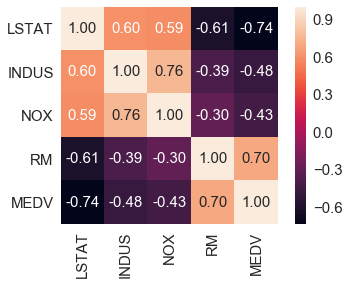

In [4]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,cbar = True,annot = True,
                 square = True,fmt = '.2f',
                 annot_kws = {'size':15},
                 yticklabels=cols,xticklabels=cols)

## 2. Models

### 2.1 Linear Regression

In [5]:
X = df[['RM']].values
y = df[['MEDV']].values
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
xs = StandardScaler()
ys = StandardScaler()
X_std = xs.fit_transform(X)
y_std = ys.fit_transform(y)
lr = LinearRegression()
lr.fit(X_std,y_std)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
def lin_regplot(X,y,model):
    plt.scatter(X,y,c = 'blue')
    plt.scatter(X,model.predict(X),color = 'red')
    return None

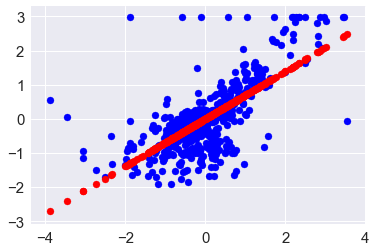

In [7]:
lin_regplot(X_std,y_std,lr)

In [8]:
num_rooms_std = xs.transform([[5.0]])
price_std = lr.predict(num_rooms_std)
ys.inverse_transform(price_std)

array([[10.83992413]])

In [9]:
lr.intercept_

array([-4.43892061e-16])

### 2.2 Estimating coefficient

In [10]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X,y)
print(slr.coef_[0],slr.intercept_)

[9.10210898] [-34.67062078]


In [11]:
slr.fit(X_std,y_std)
print(slr.coef_[0],slr.intercept_)

[0.69535995] [-4.43892061e-16]


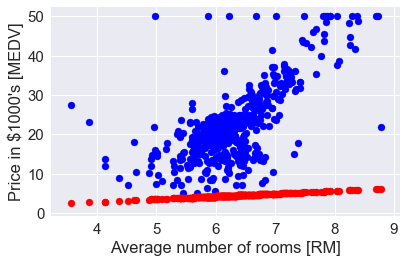

In [12]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
# plt.savefig('./figures/scikit_lr_fit.png', dpi=300)
plt.show()

### 2.3 A robust regression model using RANSAC

In [13]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                        max_trials = 100,
                         min_samples = 50,
                         residual_metric = lambda x: np.sum(np.abs(x),axis = 1),
                         residual_threshold = 5.0,
                         random_state = 0
                        )
ransac.fit(X,y)

/Users/TobiasChen/miniconda3/envs/csh/lib/python3.6/site-packages/sklearn/linear_model/ransac.py:288: DeprecationWarning: 'residual_metric' was deprecated in version 0.18 and will be removed in version 0.20. Use 'loss' instead.
  DeprecationWarning)


RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_metric=<function <lambda> at 0x11af6dbf8>,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

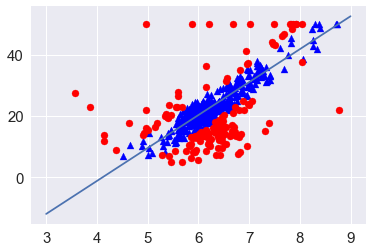

In [14]:
inliner_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inliner_mask)
line_X = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_X[:,np.newaxis])
plt.scatter(X[inliner_mask],y[inliner_mask],color = 'blue',marker = '^')
plt.scatter(X[outlier_mask],y[outlier_mask],color = 'red',marker = 'o')
plt.plot(line_X,line_y_ransac)

In [15]:
ransac.estimator_.coef_

array([[10.73450881]])

In [16]:
ransac.estimator_.intercept_

array([-44.08906429])

### 2.4 Evaluating the performance

#### 2.4.1 Residual plot

In [18]:
from sklearn.cross_validation import train_test_split
X= df.iloc[:,:-1].values
y = df['MEDV'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0,test_size = 0.3)
slr = LinearRegression()
slr.fit(X_train,y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

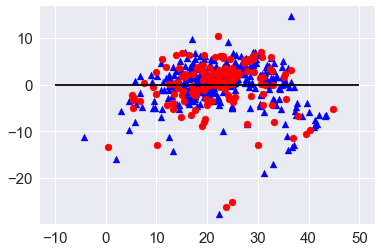

In [22]:
# Plot residual values
plt.scatter(y_train_pred,y_train_pred - y_train,c = 'blue',marker = '^',label = "Train")
plt.scatter(y_test_pred,y_test_pred - y_test,c = 'red',marker = 'o',label = "Test")
plt.hlines(y = 0,xmin = -10,xmax = 50)

#### 2.4.2 MSE

In [26]:
# MSE
from sklearn.metrics import mean_squared_error
print("training error : {}".format(round(mean_squared_error(y_train,y_train_pred),2)))
print("test error : {}".format(round(mean_squared_error(y_test,y_test_pred),2)))

training error : 19.96
test error : 27.2


#### 2.4.3 R2 score

In [28]:
# R2 score
from sklearn.metrics import r2_score
print("training error : {}".format(round(r2_score(y_train,y_train_pred),2)))
print("training error : {}".format(round(r2_score(y_test,y_test_pred),2)))

training error : 0.76
training error : 0.67


## 3. Regularition

In [ ]:
#Ridge/Lasso/Elastic Net
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
ridge = Ridge(alpha = 1.0)
lasso = Lasso(alpha = 1.0)
elastic_net = ElasticNet(alpha = 1.0, r1_ratio = 0.5)

## 4. Polynomial regression

### 4.1 Turning a linear regression model into a curve

In [29]:
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0,270.0,294.0,320.0,342.0,368.0,396.0,446.0,480.0,586.0])[:,np.newaxis]
y = np.array([236.4,234.4,252.8,298.6,314.2,342.2,360.8,368.0,391.2,390.8])

In [39]:
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree = 2)
X_quad = quadratic.fit_transform(X)

In [45]:
lr.fit(X,y)
X_fit = np.arange(250,600,10)[:,np.newaxis]
y_lin_fit = lr.predict(X_fit)

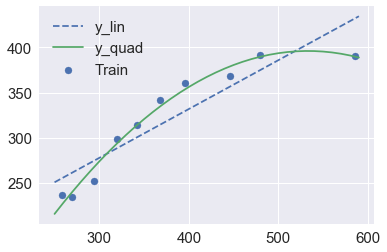

In [47]:
pr.fit(X_quad,y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))


plt.scatter(X,y,label = 'Train')
plt.plot(X_fit,y_lin_fit,label = "y_lin",linestyle = "--")
plt.plot(X_fit,y_quad_fit,label = "y_quad")
plt.legend()

In [49]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [51]:
print("line R2 : {}".format(round(r2_score(y,y_lin_pred),2)))
print("quan R2 : {}".format(round(r2_score(y,y_quad_pred),2)))

line R2 : 0.83
quan R2 : 0.98


In [52]:
print("line MSE : {}".format(round(mean_squared_error(y,y_lin_pred),2)))
print("quan MSE : {}".format(round(mean_squared_error(y,y_quad_pred),2)))

line MSE : 569.78
quan MSE : 61.33


### 4.2 Modeling nonlinear relationships in the housing dataset

In [70]:
# LSTAT and MEDV relationship and 2.3 degree polynomials
X = df[['LSTAT']].values
y = df[['MEDV']].values
# LR Model
lr = LinearRegression()
quadratic = PolynomialFeatures(degree= 2)
cubic = PolynomialFeatures(degree= 3)

In [81]:
X_fit = np.arange(X.min(),X.max(),1)[:,np.newaxis]
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

In [74]:
regr = lr.fit(X,y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y,regr.predict(X))

In [78]:
regr = lr.fit(X_quad,y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quad_r2 = r2_score(y,regr.predict(X_quad))

In [82]:
regr = lr.fit(X_cubic,y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y,regr.predict(X_cubic))

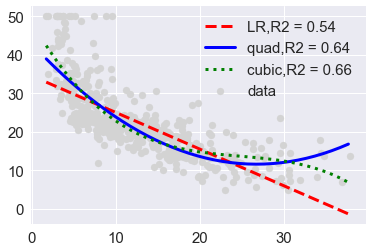

In [107]:
plt.scatter(X,y,c = 'lightgrey',marker = 'o',label = "data")
plt.plot(X_fit,y_lin_fit,label = "LR,R2 = {}".format(round(linear_r2,2)),color = 'red',linestyle = "--",lw = 3)
plt.plot(X_fit,y_quad_fit,label = "quad,R2 = {}".format(round(quad_r2,2)),color = 'blue',linestyle = "-",lw = 3)
plt.plot(X_fit,y_cubic_fit,label = "cubic,R2 = {}".format(round(cubic_r2,2)),color = 'green',linestyle = ':',lw = 3)
plt.legend(loc = "upper right")



In [108]:
# Log LSTAT and square MEDV
X_log = np.log(X)
y_sqrt = np.sqrt(y)
X_fit = np.arange(X.min()-1,X.max()+1,1)[:,np.newaxis]

In [110]:
regr = regr.fit(X_log,y_sqrt)
y_fit = regr.predict(X_fit)
r2 = r2_score(y_sqrt,regr.predict(X_log))

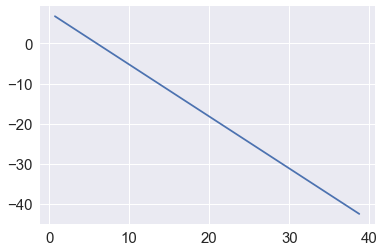

In [115]:
plt.plot(X_fit,y_fit)

In [116]:
r2

0.6909284798971007

## 5. Dealing with nonlinear relationships using random forests

### 5.1 Decision Tree Regression

Text(0,0.5,'Price in $1000')

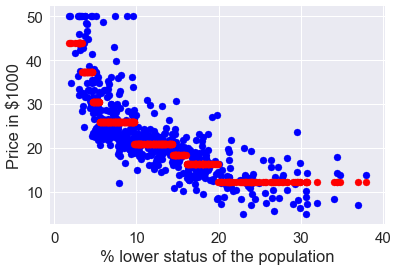

In [133]:
# DT Regression
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df[['MEDV']].values
tree = DecisionTreeRegressor(max_depth = 3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx],y[sort_idx],tree)
plt.xlabel("% lower status of the population")
plt.ylabel("Price in $1000")

### 5.2 Random Forest Regression

In [138]:
# Random Forest
X = df.iloc[:,:-1].values
y = df["MEDV"].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 0)


In [139]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 1000,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)

In [140]:
forest.fit(X_train,y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

In [145]:
print(mean_squared_error(y_train,y_train_pred))
print(mean_squared_error(y_test,y_test_pred))
print(r2_score(y_train,y_train_pred))
print(r2_score(y_test,y_test_pred))

1.443378345181515
13.138337104630569
0.9831059877432808
0.841191224808809


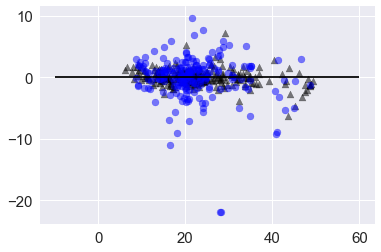

In [148]:
plt.scatter(y_train_pred,y_train_pred - y_train,c = 'black',marker = '^',alpha=0.5,label = "training")
plt.scatter(y_test_pred,y_test_pred - y_test,c = 'blue',marker = 'o',alpha=0.5,label = "testing")
plt.hlines(y = 0,xmin = -10,xmax= 60)

## 6. Summary

RANSAC:approch dealing with outlier  
Measure: MSR/r2   
Diagnose the problems of model: residual plot  
deal with non-linear relationship: polynomial feature fransformation/ random forest regressor  

## 7. Reference

Introduction to linear regression analysis (Joh Wiley)  
Vector Machines for Classification and Regression(S.R.Gunn)